# Run Correlation-Based Analyses

### Authors: Calvin Howard.

#### Last updated: July 6, 2023

Use this to assess if a correlation between a dependent variable and an independent variable is statistically significant using permutation analysis. 

Further, follow this up with a contrast analysis which sees which categorical variables have significantly different correlations from each other. 

Notes:
- To best use this notebook, you should be familar with mixed effects models

# 00 - Import CSV with All Data
**The CSV is expected to be in this format**
- ID and absolute paths to niftis are critical
```
+-----+----------------------------+--------------+--------------+--------------+
| ID  | Nifti_File_Path            | Covariate_1  | Covariate_2  | Covariate_3  |
+-----+----------------------------+--------------+--------------+--------------+
| 1   | /path/to/file1.nii.gz      | 0.5          | 1.2          | 3.4          |
| 2   | /path/to/file2.nii.gz      | 0.7          | 1.4          | 3.1          |
| 3   | /path/to/file3.nii.gz      | 0.6          | 1.5          | 3.5          |
| 4   | /path/to/file4.nii.gz      | 0.9          | 1.1          | 3.2          |
| ... | ...                        | ...          | ...          | ...          |
+-----+----------------------------+--------------+--------------+--------------+
```

In [ ]:
# Specify the path to your CSV file containing NIFTI paths
input_csv_path = '/Users/cu135/Dropbox (Partners HealthCare)/studies/cognition_2023/metadata/master_list_proper_subjects.xlsx'
sheet='master_list_proper_subjects'

In [ ]:
# Specify where you want to save your results to
out_dir = '/Users/cu135/Library/CloudStorage/OneDrive-Personal/OneDrive_Documents/Research/2023/subiculum_cognition_and_age/figures/Figures/3_cohort_delta_r'

In [ ]:
from calvin_utils.permutation_analysis_utils.statsmodels_palm import CalvinStatsmodelsPalm
# Instantiate the PalmPrepararation class
cal_palm = CalvinStatsmodelsPalm(input_csv_path=input_csv_path, output_dir=out_dir, sheet=sheet)
# Call the process_nifti_paths method
data_df = cal_palm.read_and_display_data()



# 01 - Preprocess Your Data

**Handle NANs**
- Set drop_nans=True is you would like to remove NaNs from data
- Provide a column name or a list of column names to remove NaNs from

In [ ]:
data_df.columns

In [ ]:
drop_list = ['City', 'Z_Scored_Percent_Cognitive_Improvement', 'Subiculum_Connectivity_T_Redone', 'Age_Group']

In [ ]:
data_df = cal_palm.drop_nans_from_columns(columns_to_drop_from=drop_list)
display(data_df)

**Drop Row Based on Value of Column**

Define the column, condition, and value for dropping rows
- column = 'your_column_name'
- condition = 'above'  # Options: 'equal', 'above', 'below'

Set the parameters for dropping rows

In [ ]:
column = 'City'  # The column you'd like to evaluate
condition = 'equal'  # Thecondition to check ('equal', 'above', 'below', 'not')
value = 'Queensland' # The value to compare against

In [ ]:
data_df, other_df = cal_palm.drop_rows_based_on_value(column, condition, value)
data_df

**Standardize Data**
- Enter Columns you Don't want to standardize into a list

In [ ]:
# Remove anything you don't want to standardize
cols_not_to_standardize = ['Age',  'Subiculum_Connectivity_T']

In [ ]:
data_df = cal_palm.standardize_columns(cols_not_to_standardize)
data_df

In [ ]:
data_df.describe()

# 02 - Perform Basic Correlation

In [ ]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr, kendalltau

class ScatterplotGenerator:
    def __init__(self, dataframe, data_dict, x_label='xlabel', y_label='ylabel', correlation='pearson', palette='tab10', out_dir=None, rows_per_fig=2, cols_per_fig=3, ylim=None):
        self.dataframe = dataframe
        self.data_dict = data_dict
        self.x_label = x_label
        self.y_label = y_label
        self.correlation = correlation
        self.out_dir = out_dir if out_dir else 'scatterplot_figures'
        self.palette = palette
        self.rows_per_fig = rows_per_fig
        self.cols_per_fig = cols_per_fig
        self.figures = []
        self.ylim=ylim

    def set_palette(self):
        sns.set_style('white')
        if isinstance(self.palette, str) and self.palette.startswith('#'):
            sns.set_palette(sns.color_palette([self.palette]))
        else:
            sns.set_palette(self.palette, 1, desat=1)

    def plot_scatter_with_kde(self):
        fig, axes = plt.subplots(self.rows_per_fig, self.cols_per_fig, figsize=(self.cols_per_fig * 5, self.rows_per_fig * 5))
        axes = axes.flatten()
        current_ax = 0

        for dependent_var, independent_vars in self.data_dict.items():
            self.dependent_var=dependent_var
            for independent_var in independent_vars:
                if current_ax >= len(axes):
                    self.figures.append(fig)
                    fig, axes = plt.subplots(self.rows_per_fig, self.cols_per_fig, figsize=(self.cols_per_fig * 5, self.rows_per_fig * 5))
                    axes = axes.flatten()
                    current_ax = 0

                sns.regplot(x=independent_var, y=dependent_var, data=self.dataframe, ax=axes[current_ax])

                if self.correlation == 'pearson':
                    r, p = pearsonr(self.dataframe[independent_var], self.dataframe[dependent_var])
                elif self.correlation == 'spearman':
                    r, p = spearmanr(self.dataframe[independent_var], self.dataframe[dependent_var])
                elif self.correlation == 'kendall':
                    r, p = kendalltau(self.dataframe[independent_var], self.dataframe[dependent_var])
                else:
                    raise ValueError(f'Correlation {self.correlation} not specified, please select "pearson", "kendall" or "spearman"')
                
                if self.ylim is not None:
                    axes[current_ax].set_ylim(self.ylim[0], self.ylim[1])
                
                axes[current_ax].set_title(independent_var)
                axes[current_ax].annotate(f"{self.correlation.capitalize()} r = {r:.2f}, p = {p:.3f}", xy=(.05, .95), xycoords='axes fraction', horizontalalignment='left', verticalalignment='top')
                axes[current_ax].set_xlabel(self.x_label)
                axes[current_ax].set_ylabel(self.y_label)

                current_ax += 1

        self.figures.append(fig)  # Append the last figure

    def save_plots(self):
        if self.out_dir:
            os.makedirs(self.out_dir, exist_ok=True)
            for i, fig in enumerate(self.figures):
                fig.savefig(os.path.join(self.out_dir, f'{self.dependent_var}{i}.png'))
                fig.savefig(os.path.join(self.out_dir, f'{self.dependent_var}{i}.svg'))
                print(f'Figure saved to: {os.path.join(self.out_dir, f"{self.dependent_var}{i}")}')
                plt.show()

    def run(self):
        self.set_palette()
        self.plot_scatter_with_kde()
        self.save_plots()


Define Variables to Correlate
- 

Variables to Correlate
- dependent_variable = 'Z_Scored_Percent_Cognitive_Improvement'
- independent_variable_list = ['Z_Scored_Cognitive_Baseline']


In [ ]:
data_df.columns

In [ ]:
filtered_columns = [col for col in data_df.columns if 'occi' in col.lower()]
print(filtered_columns)

In [ ]:
dependent_variable = 'Z_Scored_Percent_Cognitive_Improvement'
independent_variable_list = ['Memory_Network_T', 'Memory_Network_R', 'Subiculum_Connectivity_T_Redone']

Choose Correlation Method
- Options: 'spearman', 'pearson', 'kendall'

In [ ]:
correlation = 'spearman'

Define plot Labels
- These are the axes

In [ ]:
# Axis Labels
x_label = 'Lobe'
y_label = 'Correlation to Radiologist'

Run the Correlation

In [ ]:
# Usage Example
generator = ScatterplotGenerator(dataframe=data_df, data_dict={dependent_variable: independent_variable_list}, 
                                 x_label=x_label, y_label=y_label, correlation=correlation, 
                                 palette='Blues',
                                 rows_per_fig=1, cols_per_fig=4,
                                 ylim=None,
                                 out_dir=None)
generator.run()

Run for a Bunch of Independent Variables

In [ ]:
dep_vars = ['Subiculum_Connectivity_T', 'Memory_Network_T']
independent_variable_list = ['Age']

In [ ]:
for dep_var in dep_vars:
    generator = ScatterplotGenerator(dataframe=data_df, data_dict={dep_var: independent_variable_list}, 
                                 x_label=x_label, y_label=dep_var, correlation=correlation, 
                                 out_dir=out_dir, palette='Blues',
                                 rows_per_fig=1, cols_per_fig=2,
                                 ylim=None)
    generator.run()

# 02B - Regress Out a Variable First

In [ ]:
data_df.columns

In [ ]:
filtered_columns = [col for col in data_df.columns if 'eh' in col.lower()]
print(filtered_columns)

In [ ]:
dep_vars = ['TOTALMOD']
independent_variable_list = ['frontal_eh', 'temporal_eh', 'parietal_eh', 'occipital_eh', 'cerebellum_eh', 'mesial_temporal_eh', 'ventricle_eh']
covariates = ['Age', 'Sex']
correlation='pearson'

In [ ]:
from calvin_utils.statistical_utils.regression_utils import RegressOutCovariates
import numpy as np

df, adjusted_indep_vars_list = RegressOutCovariates.run(df=data_df, independent_variable_list=independent_variable_list, covariates_list=covariates, intercept=False)
                            
for dep_var in dep_vars:
    generator = ScatterplotGenerator(dataframe=df, data_dict={dep_var: adjusted_indep_vars_list}, 
                                x_label='X Axis', y_label=dep_var, correlation=correlation, 
                                out_dir=out_dir, palette='Blues',
                                rows_per_fig=int(np.ceil(len(independent_variable_list)/4)), cols_per_fig=int(np.ceil(len(independent_variable_list)/3)),
                                ylim=None)
    generator.run()

# 03 - Run ANCOVA-Style Analysis Using Correlation
- AKA a 'Delta-R Analysis'

In [ ]:
from statannotations.Annotator import Annotator
import pandas as pd
import numpy as np
from tqdm import tqdm
import itertools
import random
import matplotlib.pyplot as plt
import seaborn as sns

class ANCOVACorrelation:
    """
    Params:
        similarity: Bool
            - This determins if the delta-r analysis will be performed to assess if the correlations are MORE SIMILAR THAN EXPECTED.
            - Defaults to False, which evalutes if they are MORE DIFFERENCE THAN EXPECTED. 
        two_tail: Bool
            - This determines if a two-tailed p-value derivation will be performed. 
            - Set to false to generate a one-tail. 
    """
    def __init__(self, df, dependent_variable, independent_variable, categorical_variable, spearman=False, out_dir=None, n_permutations=10000, similarity=False, two_tail=True):
        self.df = df
        self.dependent_variable = dependent_variable
        self.independent_variable = independent_variable
        self.categorical_variable = categorical_variable
        self.out_dir = out_dir
        self.similarity = similarity
        self.two_tail = two_tail
        # Initialize a dictionary to store dataframes for each category
        self.category_dataframes = {}
        
        # Initialize a dictionary to store observed correlations
        self.observed_correlations = {}
        
        # Call the segregator function to split the data
        self.segregate_data()
        self.spearman=spearman
        
        self.n_permutations=n_permutations
    
    def segregate_data(self):
        # Group the data by unique values of the categorical variable
        unique_categories = self.df[self.categorical_variable].unique()
        
        # Create separate dataframes for each category
        for category in unique_categories:
            self.category_dataframes[category] = self.df[self.df[self.categorical_variable] == category]
    
    def calculate_correlation(self, category):
        # Calculate the correlation between independent and dependent variables for a given category
        category_df = self.category_dataframes.get(category)
        if category_df is not None:
            if self.spearman:
                correlation = category_df[self.independent_variable].corr(category_df[self.dependent_variable], method='spearman')
            else:
                correlation = category_df[self.independent_variable].corr(category_df[self.dependent_variable])
            self.observed_correlations[category] = correlation
        else:
            print(f"Category '{category}' not found in the data.")

            
    def calculate_observed_r_values(self):
        # Calculate observed r values for each category and store them
        self.observed_correlations = {}
        for category in self.category_dataframes.keys():
            correlation = self.calculate_correlation(category)
            if correlation is not None:
                self.observed_correlations[category] = correlation

    def permute_and_calculate_correlations(self):
        # Initialize a dictionary to store permuted correlations for each category
        self.permuted_correlations = {category: [] for category in self.category_dataframes.keys()}

        for _ in tqdm(range(self.n_permutations), desc="Permutations"):
            # Create a copy of the original data to permute
            permuted_data = self.df.copy()

            # Loop through each category's dataframe
            for category, category_df in self.category_dataframes.items():
                # Permute the outcomes (dependent variable) within the category's dataframe
                category_outcomes = category_df[self.dependent_variable].values
                random.shuffle(category_outcomes)
                permuted_data.loc[category_df.index, self.dependent_variable] = category_outcomes

                # Calculate and store the correlation with the independent variable
                correlation = category_df[self.independent_variable].corr(permuted_data.loc[category_df.index, self.dependent_variable])
                self.permuted_correlations[category].append(correlation)
                
    def calculate_p_values(self):
        '''
        This calculate a two-tailed p-value.
        '''
        # Initialize a dictionary to store p-values for each category
        self.p_values = {category: None for category in self.category_dataframes.keys()}

        for category in self.category_dataframes.keys():
            observed_val = self.observed_correlations[category]
            permuted_dist = self.permuted_correlations[category]

            # Calculate the p-value
            p_value = np.mean(np.array(np.abs(permuted_dist)) > np.abs(observed_val))

            self.p_values[category] = p_value
            
    def calculate_delta_r(self):
        # Initialize a dictionary to store Delta-R values and their significance for each category combination
        self.delta_r_values = {}
        
        # Get all unique combinations of categories
        category_combinations = list(itertools.combinations(self.category_dataframes.keys(), 2))

        for category1, category2 in category_combinations:
            observed_val1 = self.observed_correlations[category1]
            observed_val2 = self.observed_correlations[category2]

            # Get the permuted distributions for both categories
            permuted_dist1 = self.permuted_correlations[category1]
            permuted_dist2 = self.permuted_correlations[category2]

            delta_r = observed_val1 - observed_val2
            delta_r_permuted = np.array(permuted_dist1) - np.array(permuted_dist2)

            # Calculate the significance using a two-tailed test
            if self.two_tail:
                delta_r = np.abs(delta_r)
                delta_r_permuted = np.abs(delta_r_permuted)
            if self.similarity:
                p_value = np.mean(delta_r_permuted < delta_r)
            else:
                p_value = np.mean(delta_r_permuted > delta_r)
            # Store the Delta-R value and its significance
            self.delta_r_values[(category1, category2)] = {
                'delta_r': delta_r,
                'p_value': p_value
            }

    def plot_correlations(self):
        # Convert observed correlations data to a DataFrame
        observed_data = pd.DataFrame({
            'Category': self.observed_correlations.keys(),
            'Correlation': self.observed_correlations.values()
        })

        # Set style and increase font size
        sns.set_style("white")
        # sns.set(font_scale=1)

        # Create the bar plot using the observed data
        sns.barplot(x='Category', y='Correlation', data=observed_data, palette='tab10')
        sns.despine()
        # # Add p-value annotations using Annotator
        p_values = [self.delta_r_values[comb]['p_value'] for comb in self.delta_r_values]
        combinations = [f'{comb[0]} vs {comb[1]}' for comb in self.delta_r_values]
        data = pd.DataFrame({'Combination': combinations, 'p-value': p_values})
        # annotator = Annotator(ax=ax, data=data, x='Combination', y='p-value', loc='outside', fontsize=12)

        # Save the figure if out_dir is provided
        if self.out_dir:
            plt.savefig(f"{self.out_dir}/delta_correlation_plot.png", bbox_inches='tight')
            plt.savefig(f"{self.out_dir}/delta_correlation_plot.svg", bbox_inches='tight')
            print(f'Saved to {self.out_dir}/delta_correlation_plot.svg')

        # Show the plot
        plt.show()
        return observed_data, data
        
    def run(self):
        self.segregate_data()
        self.calculate_observed_r_values()
        self.permute_and_calculate_correlations()
        self.calculate_p_values()
        self.calculate_delta_r()
        single_data, delta_data = self.plot_correlations()
        return single_data, delta_data

    def create_combined_plot(self, group_variable, dependent_variable):
        sns.set()

        fig, ax = plt.subplots(nrows=len(self.df[group_variable].unique()), sharex=True)
        ax[-1].set_xlabel(dependent_variable)

        for i, group_val in enumerate(self.df[group_variable].unique()):
            group_data = self.df[self.df[group_variable] == group_val][dependent_variable]
            jittered_group_data = group_data + 0.1 * (2 * random.random() - 1)  # Add small vertical jitter
            ax[i].scatter(jittered_group_data, [0] * len(group_data))
            sns.kdeplot(group_data, ax=ax[i], shade=False, legend=False)
            ax[i].set_yticks([])
            ax[i].set_ylim(-0.01)
            ax[i].set_ylabel(f'{group_variable} ' + str(group_val))

        plt.show()
        
    def plot_correlations_with_lmplot(self, palette='Tab10'):
        # Using seaborn's lmplot to plot linear regression lines for each category
        if self.spearman:
            print('Have rank-transformed data for visualization of Spearman correlation.')
            self.df = self.df.rank()
        lm = sns.lmplot(x=self.independent_variable, y=self.dependent_variable, 
                        hue=self.categorical_variable, data=self.df, 
                        aspect=1.5, height=5, palette=palette, legend=False, ci=0)

        # Enhancements for better readability
        lm.set_xlabels(f"{self.independent_variable}")
        lm.set_ylabels(f"{self.dependent_variable}")
        plt.title("Correlation Split by Category")
        plt.legend()
        # Save the figure if out_dir is provided
        if self.out_dir:
            plt.savefig(f"{self.out_dir}/delta_correlation_plot.png", bbox_inches='tight')
            plt.savefig(f"{self.out_dir}/delta_correlation_plot.svg", bbox_inches='tight')
            print(f'Saved to {self.out_dir}/delta_correlation_plot.svg')
        plt.show()

In [ ]:
data_df.columns

Enter Variables
- dependent_variable: the name of the dependent variable
- independent_variable: the name of the independent variable
- categorical_variable: the column containing categorical information. This may be strings or numbers. 

In [ ]:
data_df.columns

Melt a Dataframe if Needed
- This will allow you to set all DV values and IV values in two columns, with a third column containing the categories of the IV values. 

In [ ]:
data_df.columns

In [ ]:
dependent_variable = 'Percent_Cognitive_Improvement'
independent_variable_list = ['Subiculum_Connectivity_T_Redone', 'Age_Group']

In [ ]:
import pandas as pd
# Reshaping the DataFrame
melted_df = pd.melt(data_df, id_vars=[dependent_variable], value_vars=independent_variable_list, 
                    var_name='Category', value_name='Value')
melted_df

In [ ]:
dependent_variable = 'Percent_Cognitive_Improvement'
independent_variable = 'Subiculum_Connectivity_T_Redone'
categorical_variable = 'Age_Group'

Do You Want to Run A Spearman Correlation?

In [ ]:
spearman = True
two_tail = True
similarity = False

# 04 - Run the Correlational ANCOVA

In [ ]:
delta_r = ANCOVACorrelation(df=data_df, dependent_variable=dependent_variable, independent_variable=independent_variable, categorical_variable=categorical_variable, out_dir=out_dir, spearman=spearman,
                            n_permutations=10000, similarity=similarity, two_tail=two_tail)
single_data, delta_data = delta_r.run()
delta_data

In [ ]:
single_data

Save the Output CSV

In [ ]:
out_dir

In [ ]:
import os
print(os.path.join(out_dir, f'{dependent_variable}_delta_rho.csv'))
delta_data.to_csv(os.path.join(out_dir, '{dependent_variable}_delta_rho.csv'))

Visualize Scatter

In [ ]:
delta_r.plot_correlations_with_lmplot(palette='Set1')

In [ ]:
single_data

# Visualize Correlational ANCOVA

Enter these values

In [414]:
data_df.columns

Index(['subject', 'Age', 'Normalized_Percent_Cognitive_Improvement',
       'Z_Scored_Percent_Cognitive_Improvement_By_Origin_Group',
       'Z_Scored_Percent_Cognitive_Improvement',
       'Percent_Cognitive_Improvement',
       'Z_Scored_Subiculum_T_By_Origin_Group_',
       'Z_Scored_Subiculum_Connectivity_T', 'Subiculum_Connectivity_T_Redone',
       'Subiculum_Connectivity_T', 'Amnesia_Lesion_T_Map', 'Memory_Network_T',
       'Z_Scored_Memory_Network_R', 'Memory_Network_R',
       'Subiculum_Grey_Matter', 'Subiculum_White_Matter', 'Subiculum_CSF',
       'Subiculum_Total', 'Standardized_Age',
       'Standardized_Percent_Improvement',
       'Standardized_Subiculum_Connectivity',
       'Standardized_Subiculum_Grey_Matter',
       'Standardized_Subiculum_White_Matter', 'Standardized_Subiculum_CSF',
       'Standardized_Subiculum_Total', 'Disease', 'Cohort', 'City',
       'Inclusion_Cohort', 'Categorical_Age_Group', 'Age_Group',
       'Age_And_Disease', 'Age_Disease_and_Cohort',

In [416]:
out_dir='/Users/cu135/Library/CloudStorage/OneDrive-Personal/OneDrive_Documents/Research/2023/subiculum_cognition_and_age/figures/Figures/3_cohort_delta_r/split_by_sbc_group'

In [417]:
# Assuming data_prep and category_dataframes are already defined
dependent_variable = 'Z_Scored_Percent_Cognitive_Improvement'
independent_variable = 'Age'
categorical_variable = 'Subiculum_Group_By_24'
cohort_variable = 'City'

In [418]:
import pandas as pd
import numpy as np

class DataPreparation:
    """
    A class used to segregate data by categorical variables and optional cohorts.

    Attributes:
    ----------
    df : pd.DataFrame
        The input dataframe containing the data.
    dependent_variable : str
        The name of the dependent variable column.
    independent_variable : str
        The name of the independent variable column.
    categorical_variable : str
        The name of the categorical variable column used for splitting.
    cohort_variable : str, optional
        The name of the cohort variable column used for additional splitting. Default is None.

    Methods:
    -------
    segregate_data():
        Splits the dataframe into nested dictionaries by cohort and category.

    Example Usage:
    -------------
    dependent_variable = 'Z_Scored_Percent_Cognitive_Improvement'
    independent_variable = 'Subiculum_Connectivity_T_Redone'
    categorical_variable = 'Age_Group'
    cohort_variable = 'City'  # Optional, can be None if not needed

    data_prep = DataPreparation(data_df, dependent_variable, independent_variable, categorical_variable, cohort_variable)
    category_dataframes = data_prep.category_dataframes

    for cohort, categories in category_dataframes.items():
        print(f"Cohort: {cohort}")
        for category, cat_df in categories.items():
            print(f"  Category: {category}")
            print(cat_df.head())
    """

    def __init__(self, df, dependent_variable, independent_variable, categorical_variable, cohort_variable=None):
        self.dependent_variable = dependent_variable
        self.independent_variable = independent_variable
        self.categorical_variable = categorical_variable
        self.cohort_variable = cohort_variable
        self.df = self.prepare_dataframe(df)
        self.category_dataframes = self.segregate_data()
        self.category_dataframes = self.reverse_dictionary()
        
    def prepare_dataframe(self, df):
        if self.cohort_variable is None:
            df = df.loc[:, [self.dependent_variable, self.independent_variable, self.categorical_variable]]
        else:
            df = df.loc[:, [self.dependent_variable, self.independent_variable, self.categorical_variable, self.cohort_variable]]
        return df
    
    def segregate_data(self):
        """
        Splits the dataframe into nested dictionaries by cohort and category.

        Returns:
        -------
        dict
            A nested dictionary where data is first split by cohort (if provided) and then by category.
            Each entry corresponds to a subset of the data for a specific cohort and category.
        """
        # Initialize dictionary to hold dataframes for each category
        category_dataframes = {}
        unique_categories = self.df[self.categorical_variable].unique()
        # We do not need to split by cohort, as we can iterate over each cohort during plotting. 
        for category in unique_categories:
            category_dataframes[category] = self.df[self.df[self.categorical_variable] == category]
        category_dataframes['all_categories'] = self.df
        return category_dataframes
    
    def reverse_dictionary(self):
        reversed_dict = {k: self.category_dataframes[k] for k in reversed(self.category_dataframes)}
        return reversed_dict

In [419]:
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

class ScatterPlot:
    """
    A class to create scatter plots with linear regression lines for each category and cohort.

    Attributes:
    ----------
    data_prep : DataPreparation
        An instance of the DataPreparation class containing the processed data.
    colors : list
        List of colors for each category.

    Methods:
    -------
    get_colors(colors_list):
        Generates a list of colors for plotting.
    get_scatterplots():
        Creates scatter plots with linear regression lines for each category and cohort.
    plot():
        Plots the scatter plots.
    """

    def __init__(self, data_prep, colors_list=None, confidence_intervals=False):
        self.data_prep = data_prep
        self.colors = self.get_colors(colors_list)
        self.scatterplots_dict = self.get_scatterplots(confidence_intervals)
        
    def get_colors(self, colors_list):
        if colors_list is not None:
            return sns.color_palette(colors_list, len(self.data_prep.df[self.data_prep.cohort_variable].unique()))
        else:
            return sns.color_palette("tab10", len(self.data_prep.df[self.data_prep.cohort_variable].unique()))

    def get_scatterplots(self,confidence_intervals):
        scatterplots_dict = {}
        for name, dataframe in self.data_prep.category_dataframes.items():
            fig, ax = plt.subplots(figsize=(6, 6))
            
            if self.data_prep.cohort_variable is not None: 
                for i, cohort in enumerate(dataframe[self.data_prep.cohort_variable].unique()):
                    cohort_df = dataframe[dataframe[self.data_prep.cohort_variable] == cohort]
                    sns.regplot(x=self.data_prep.independent_variable, 
                                y=self.data_prep.dependent_variable, 
                                data=cohort_df, ax=ax, label=cohort, color=self.colors[i],
                                ci=confidence_intervals)
            else:
                sns.regplot(x=self.data_prep.independent_variable, 
                            y=self.data_prep.dependent_variable, 
                            data=dataframe, ax=ax, label=name, color=self.colors[0],
                            ci=confidence_intervals)
                
            ax.legend()
            plt.title(name)
            plt.tight_layout()
            scatterplots_dict[name] = fig
            plt.close()

        return scatterplots_dict

    def plot(self):
        import warnings
        for name, fig in self.scatterplots_dict.items():
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("error", UserWarning)
                    fig.show()
            except UserWarning:
                from IPython.display import display
                display(fig)


In [420]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

class BarPlot:
    """
    A class to create bar plots summarizing the correlation strengths for each category and cohort.

    Attributes:
    ----------
    data_prep : DataPreparation
        An instance of the DataPreparation class containing the processed data.
    colors : list
        List of colors for each cohort.

    Methods:
    -------
    get_colors(colors_list):
        Generates a list of colors for plotting.
    get_barplots(method):
        Creates bar plots summarizing the correlation strengths for each category and cohort.
    plot():
        Plots the bar plots.
    """

    def __init__(self, data_prep, colors_list=None, method='pearson'):
        self.data_prep = data_prep
        self.colors = self.get_colors(colors_list)
        self.method = method
        self.barplots_dict = self.get_barplots()
        self.set_shared_y_limits()
        
    def get_colors(self, colors_list):
        if colors_list is not None:
            return sns.color_palette(colors_list, len(self.data_prep.df[self.data_prep.cohort_variable].unique()))
        else:
            return sns.color_palette("tab10", len(self.data_prep.df[self.data_prep.cohort_variable].unique()))

    def get_barplots(self):
        barplots_dict = {}
        all_correlations = []

        for name, dataframe in self.data_prep.category_dataframes.items():
            correlations = {}
            p_values = {}

            if self.data_prep.cohort_variable is not None:
                for i, cohort in enumerate(dataframe[self.data_prep.cohort_variable].unique()):
                    cohort_df = dataframe[dataframe[self.data_prep.cohort_variable] == cohort]
                    if self.method == 'pearson':
                        correlation, p_value = pearsonr(cohort_df[self.data_prep.independent_variable], cohort_df[self.data_prep.dependent_variable])
                    else:  # spearman
                        correlation, p_value = spearmanr(cohort_df[self.data_prep.independent_variable], cohort_df[self.data_prep.dependent_variable])
                    correlations[cohort] = correlation
                    p_values[cohort] = p_value
                    all_correlations.append(correlation)
            else:
                if self.method == 'pearson':
                    correlation, p_value = pearsonr(dataframe[self.data_prep.independent_variable], dataframe[self.data_prep.dependent_variable])
                else:  # spearman
                    correlation, p_value = spearmanr(dataframe[self.data_prep.independent_variable], dataframe[self.data_prep.dependent_variable])
                correlations[name] = correlation
                p_values[name] = p_value
                all_correlations.append(correlation)

            fig, ax = plt.subplots(figsize=(6, 6))
            bars = sns.barplot(y=list(correlations.keys()), x=list(correlations.values()), ax=ax, palette=self.colors[:len(correlations)])
            ax.set_xlabel('Correlation Strength')
            ax.set_title(name)

            # Outline bars with p-value < 0.05
            for j, bar in enumerate(bars.patches):
                cohort_name = list(correlations.keys())[j]
                if p_values[cohort_name] < 0.05:
                    bar.set_edgecolor('black')
                    bar.set_linewidth(1.5)

            plt.tight_layout()
            barplots_dict[name] = fig
            plt.close()

        self.y_min = min(all_correlations)
        self.y_max = max(all_correlations)

        return barplots_dict

    def set_shared_y_limits(self):
        for name, fig in self.barplots_dict.items():
            ax = fig.get_axes()[0]
            ax.set_xlim(self.y_min, self.y_max)

    def plot(self):
        import warnings
        for name, fig in self.barplots_dict.items():
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("error", UserWarning)
                    fig.show()
            except UserWarning:
                from IPython.display import display
                display(fig)

In [421]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

class CombinedPlotV1:
    """
    A class to create a combined plot of scatter plots and bar plots.

    Attributes:
    ----------
    scatter_plot : ScatterPlot
        An instance of the ScatterPlot class containing the scatter plots.
    bar_plot : BarPlot
        An instance of the BarPlot class containing the bar plots.
    out_dir : str
        Directory to save the output plot.

    Methods:
    -------
    create_figure():
        Creates a combined figure with scatter plots and bar plots.
    """

    def __init__(self, scatter_plot, bar_plot, out_dir=None):
        self.scatter_plot = scatter_plot
        self.bar_plot = bar_plot
        self.out_dir = out_dir
        self.fig, self.axes = self.create_figure()

    def create_figure(self):
        """
        Creates a combined figure with scatter plots and bar plots.
        """
        categories = list(self.scatter_plot.data_prep.category_dataframes.keys())
        num_categories = len(categories)

        fig, axes = plt.subplots(num_categories, 2, figsize=(15, 6 * num_categories))

        for i, category in enumerate(categories):
            # Scatter Plot
            scatter_ax = axes[i, 0]
            scatter_fig = self.scatter_plot.scatterplots_dict[category]
            scatter_canvas = scatter_fig.canvas
            scatter_canvas.draw()
            scatter_image = scatter_canvas.buffer_rgba()
            scatter_ax.imshow(scatter_image)
            scatter_ax.axis('off')

            # Bar Plot
            bar_ax = axes[i, 1]
            bar_fig = self.bar_plot.barplots_dict[category]
            bar_canvas = bar_fig.canvas
            bar_canvas.draw()
            bar_image = bar_canvas.buffer_rgba()
            bar_ax.imshow(bar_image)
            bar_ax.axis('off')

        plt.tight_layout()

        if self.out_dir:
            plt.savefig(f"{self.out_dir}/combined_plot.svg", format='svg')
        plt.close()
        return fig, axes
    
    def plot(self):
        import warnings
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("error", UserWarning)
                self.fig.show()
        except UserWarning:
            from IPython.display import display
            display(self.fig)

contrast cohorts within categories

In [422]:
import numpy as np

class PermutationAnalysis:
    def __init__(self, data_prep):
        self.data_prep = data_prep
        self.observed_correlations = {}
        self.permuted_differences = {}
        self.p_values = {}

    def calculate_observed_differences(self, df):
        """Calculate the observed differences for each cohort within a dataframe."""
        observed_correlations = {}
        for cohort in df[self.data_prep.cohort_variable].unique():
            cohort_df = df[df[self.data_prep.cohort_variable] == cohort]
            correlation = cohort_df[self.data_prep.independent_variable].corr(cohort_df[self.data_prep.dependent_variable])
            observed_correlations[cohort] = correlation

        observed_differences = {}
        cohorts = list(observed_correlations.keys())
        for i in range(len(cohorts)):
            for j in range(i + 1, len(cohorts)):
                cohort1, cohort2 = cohorts[i], cohorts[j]
                diff = observed_correlations[cohort1] - observed_correlations[cohort2]
                observed_differences[(cohort1, cohort2)] = diff

        return observed_differences

    def calculate_permuted_differences(self, df, n_permutations=1000):
        """Permute the data and calculate the permuted differences for each cohort within a dataframe."""
        permuted_differences = []

        for _ in range(n_permutations):
            permuted_df = df.copy()
            permuted_df[self.data_prep.dependent_variable] = np.random.permutation(permuted_df[self.data_prep.dependent_variable].values)
            correlations = {}
            for cohort in df[self.data_prep.cohort_variable].unique():
                cohort_df = permuted_df[permuted_df[self.data_prep.cohort_variable] == cohort]
                correlation = cohort_df[self.data_prep.independent_variable].corr(cohort_df[self.data_prep.dependent_variable])
                correlations[cohort] = correlation

            permuted_diffs = {}
            cohorts = list(correlations.keys())
            for i in range(len(cohorts)):
                for j in range(i + 1, len(cohorts)):
                    cohort1, cohort2 = cohorts[i], cohorts[j]
                    diff = correlations[cohort1] - correlations[cohort2]
                    permuted_diffs[(cohort1, cohort2)] = diff

            permuted_differences.append(permuted_diffs)

        return permuted_differences

    def calculate_p_values(self, observed_differences, permuted_differences):
        """Calculate p-values based on the observed and permuted differences."""
        p_values = {}
        for (cohort1, cohort2), observed_diff in observed_differences.items():
            permuted_diffs = [permuted[(cohort1, cohort2)] for permuted in permuted_differences]
            p_value = np.mean([diff >= observed_diff for diff in permuted_diffs])
            p_values[(cohort1, cohort2)] = p_value

        return p_values

    def run_analysis(self, n_permutations=1000):
        """Run the entire permutation analysis for each dataframe in the data_prep object."""
        for category, df in self.data_prep.category_dataframes.items():
            observed_differences = self.calculate_observed_differences(df)
            permuted_differences = self.calculate_permuted_differences(df, n_permutations)
            p_values = self.calculate_p_values(observed_differences, permuted_differences)
            self.p_values[category] = p_values

contrast across categories

In [423]:
import numpy as np

class ContrastAnalysis:
    def __init__(self, perm_analysis):
        self.perm_analysis = perm_analysis
        self.summed_correlations = {}
        self.cross_dataframe_differences = {}
        self.cross_dataframe_p_values = {}

    def summate_correlations(self):
        """Summate the correlations within each dataframe."""
        for category, df in self.perm_analysis.data_prep.category_dataframes.items():
            summed_correlation = 0
            for cohort in df[self.perm_analysis.data_prep.cohort_variable].unique():
                cohort_df = df[df[self.perm_analysis.data_prep.cohort_variable] == cohort]
                correlation = cohort_df[self.perm_analysis.data_prep.independent_variable].corr(cohort_df[self.perm_analysis.data_prep.dependent_variable])
                summed_correlation += correlation
            self.summed_correlations[category] = summed_correlation

    def calculate_cross_dataframe_differences(self, n_permutations=1000):
        """Calculate the difference between summed correlations from different dataframes and calculate p-values."""
        categories = list(self.summed_correlations.keys())
        for i in range(len(categories)):
            for j in range(i + 1, len(categories)):
                category1, category2 = categories[i], categories[j]
                observed_diff = self.summed_correlations[category1] - self.summed_correlations[category2]
                self.cross_dataframe_differences[(category1, category2)] = observed_diff

                permuted_diffs = []
                for _ in range(n_permutations):
                    permuted_df1 = self.perm_analysis.data_prep.category_dataframes[category1].copy()
                    permuted_df2 = self.perm_analysis.data_prep.category_dataframes[category2].copy()

                    permuted_df1[self.perm_analysis.data_prep.dependent_variable] = np.random.permutation(permuted_df1[self.perm_analysis.data_prep.dependent_variable].values)
                    permuted_df2[self.perm_analysis.data_prep.dependent_variable] = np.random.permutation(permuted_df2[self.perm_analysis.data_prep.dependent_variable].values)

                    permuted_sum1 = 0
                    for cohort in permuted_df1[self.perm_analysis.data_prep.cohort_variable].unique():
                        cohort_df = permuted_df1[permuted_df1[self.perm_analysis.data_prep.cohort_variable] == cohort]
                        correlation = cohort_df[self.perm_analysis.data_prep.independent_variable].corr(cohort_df[self.perm_analysis.data_prep.dependent_variable])
                        permuted_sum1 += correlation

                    permuted_sum2 = 0
                    for cohort in permuted_df2[self.perm_analysis.data_prep.cohort_variable].unique():
                        cohort_df = permuted_df2[permuted_df2[self.perm_analysis.data_prep.cohort_variable] == cohort]
                        correlation = cohort_df[self.perm_analysis.data_prep.independent_variable].corr(cohort_df[self.perm_analysis.data_prep.dependent_variable])
                        permuted_sum2 += correlation

                    permuted_diff = permuted_sum1 - permuted_sum2
                    permuted_diffs.append(permuted_diff)

                p_value = np.mean([diff >= observed_diff for diff in permuted_diffs])
                self.cross_dataframe_p_values[(category1, category2)] = p_value

Get the difference across categories and cohorts

In [424]:
import numpy as np
import pandas as pd
from pprint import pprint

class CrossCategoryPermutationAnalysis:
    def __init__(self, perm_analysis):
        self.perm_analysis = perm_analysis
        self.observed_correlations = {}
        self.permuted_correlations = []
        self.observed_differences = {}
        self.permuted_differences = []
        self.p_values = {}

    def calculate_observed_correlations(self):
        """Calculate the observed correlations for each cohort within each category dataframe."""
        for category, df in self.perm_analysis.data_prep.category_dataframes.items():
            self.observed_correlations[category] = {}
            for cohort in df[self.perm_analysis.data_prep.cohort_variable].unique():
                cohort_df = df[df[self.perm_analysis.data_prep.cohort_variable] == cohort]
                correlation = cohort_df[self.perm_analysis.data_prep.independent_variable].corr(cohort_df[self.perm_analysis.data_prep.dependent_variable])
                self.observed_correlations[category][cohort] = correlation

    def calculate_observed_differences(self):
        """Calculate the differences between correlations of every cohort in one category dataframe against every cohort in other category dataframes."""
        categories = list(self.observed_correlations.keys())
        for i in range(len(categories)):
            for j in range(i + 1, len(categories)):
                category1, category2 = categories[i], categories[j]
                self.observed_differences[(category1, category2)] = {}
                for cohort1, corr1 in self.observed_correlations[category1].items():
                    for cohort2, corr2 in self.observed_correlations[category2].items():
                        diff = corr1 - corr2
                        self.observed_differences[(category1, category2)][(cohort1, cohort2)] = diff

    def calculate_permuted_differences(self, n_permutations=1000):
        """Permute the data and calculate the permuted differences for each permutation."""
        categories = list(self.perm_analysis.data_prep.category_dataframes.keys())
        all_data = pd.concat(self.perm_analysis.data_prep.category_dataframes.values())

        for _ in range(n_permutations):
            permuted_data = all_data.copy()
            permuted_data[self.perm_analysis.data_prep.dependent_variable] = np.random.permutation(permuted_data[self.perm_analysis.data_prep.dependent_variable].values)

            permuted_correlations = {}
            for category in categories:
                permuted_correlations[category] = {}
                df = permuted_data[permuted_data[self.perm_analysis.data_prep.categorical_variable] == category]
                for cohort in df[self.perm_analysis.data_prep.cohort_variable].unique():
                    cohort_df = df[df[self.perm_analysis.data_prep.cohort_variable] == cohort]
                    correlation = cohort_df[self.perm_analysis.data_prep.independent_variable].corr(cohort_df[self.perm_analysis.data_prep.dependent_variable])
                    permuted_correlations[category][cohort] = correlation

            permuted_diffs = {}
            for i in range(len(categories)):
                for j in range(i + 1, len(categories)):
                    category1, category2 = categories[i], categories[j]
                    permuted_diffs[(category1, category2)] = {}
                    for cohort1, corr1 in permuted_correlations[category1].items():
                        for cohort2, corr2 in permuted_correlations[category2].items():
                            diff = corr1 - corr2
                            permuted_diffs[(category1, category2)][(cohort1, cohort2)] = diff

            self.permuted_differences.append(permuted_diffs)

    def calculate_p_values(self):
        """Calculate p-values based on the observed and permuted differences."""
        categories = list(self.observed_correlations.keys())
        for i in range(len(categories)):
            for j in range(i + 1, len(categories)):
                category1, category2 = categories[i], categories[j]
                self.p_values[(category1, category2)] = {}
                for (cohort1, cohort2), observed_diff in self.observed_differences[(category1, category2)].items():
                    permuted_diffs = [permuted[(category1, category2)][(cohort1, cohort2)] for permuted in self.permuted_differences if (category1, category2) in permuted and (cohort1, cohort2) in permuted[(category1, category2)]]
                    p_value = np.mean([diff >= observed_diff for diff in permuted_diffs])
                    self.p_values[(category1, category2)][(cohort1, cohort2)] = p_value

    def run_cross_category_permutation_analysis(self, n_permutations=1000):
        """Run the entire cross-category permutation analysis."""
        self.calculate_observed_correlations()
        self.calculate_observed_differences()
        self.calculate_permuted_differences(n_permutations)
        self.calculate_p_values()

Run It All

In [425]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

class CombinedPlot:
    """
    A class to create a combined plot of scatter plots and bar plots.

    Attributes:
    ----------
    scatter_plot : ScatterPlot
        An instance of the ScatterPlot class containing the scatter plots.
    bar_plot : BarPlot
        An instance of the BarPlot class containing the bar plots.
    out_dir : str
        Directory to save the output plot.

    Methods:
    -------
    create_figure():
        Creates a combined figure with scatter plots and bar plots.
    plot():
        Displays the combined figure.
    save_figure():
        Saves the combined figure.
    """

    def __init__(self, scatter_plot, bar_plot, out_dir=None):
        self.scatter_plot = scatter_plot
        self.bar_plot = bar_plot
        self.out_dir = out_dir
        self.fig, self.axes = self.create_figure()
        self.set_shared_x_limits()

    def set_shared_x_limits(self):
        """
        Sets the x-limits for scatter plots and bar plots to be shared separately.
        """
        scatter_x_limits = [self.axes[i, 0].get_xlim() for i in range(self.axes.shape[0])]
        scatter_x_min = min([lim[0] for lim in scatter_x_limits])
        scatter_x_max = max([lim[1] for lim in scatter_x_limits])

        bar_x_limits = [self.axes[i, 1].get_xlim() for i in range(self.axes.shape[0])]
        bar_x_min = min([lim[0] for lim in bar_x_limits])
        bar_x_max = max([lim[1] for lim in bar_x_limits])

        for i in range(self.axes.shape[0]):
            self.axes[i, 0].set_xlim(scatter_x_min, scatter_x_max)
            self.axes[i, 1].set_xlim(bar_x_min, bar_x_max)

    def create_figure(self):
        """
        Creates a combined figure with scatter plots and bar plots.
        """
        categories = list(self.scatter_plot.data_prep.category_dataframes.keys())
        num_categories = len(categories)

        fig, axes = plt.subplots(num_categories, 2, figsize=(15, 6 * num_categories))

        for i, category in enumerate(categories):
            # Scatter Plot
            scatter_ax = axes[i, 0]
            scatter_data = self.scatter_plot.data_prep.category_dataframes[category]
            if self.scatter_plot.data_prep.cohort_variable is not None:
                for j, cohort in enumerate(scatter_data[self.scatter_plot.data_prep.cohort_variable].unique()):
                    cohort_df = scatter_data[scatter_data[self.scatter_plot.data_prep.cohort_variable] == cohort]
                    sns.regplot(
                        x=self.scatter_plot.data_prep.independent_variable,
                        y=self.scatter_plot.data_prep.dependent_variable,
                        data=cohort_df,
                        ax=scatter_ax,
                        label=cohort,
                        color=self.scatter_plot.colors[j],
                        ci=None
                    )
            else:
                sns.regplot(
                    x=self.scatter_plot.data_prep.independent_variable,
                    y=self.scatter_plot.data_prep.dependent_variable,
                    data=scatter_data,
                    ax=scatter_ax,
                    label=category,
                    color=self.scatter_plot.colors[0],
                    ci=None
                )
            scatter_ax.legend()
            scatter_ax.set_title(category)
            scatter_ax.set_xlabel(self.scatter_plot.data_prep.independent_variable)
            scatter_ax.set_ylabel(self.scatter_plot.data_prep.dependent_variable)

            # Bar Plot
            bar_ax = axes[i, 1]
            bar_data = self.bar_plot.data_prep.category_dataframes[category]
            correlations = []
            p_values = []
            cohorts = []

            if self.bar_plot.data_prep.cohort_variable is not None:
                for j, cohort in enumerate(bar_data[self.bar_plot.data_prep.cohort_variable].unique()):
                    cohort_df = bar_data[bar_data[self.bar_plot.data_prep.cohort_variable] == cohort]
                    if self.bar_plot.method == 'pearson':
                        correlation, p_value = pearsonr(
                            cohort_df[self.bar_plot.data_prep.independent_variable],
                            cohort_df[self.bar_plot.data_prep.dependent_variable]
                        )
                    else:
                        correlation, p_value = spearmanr(
                            cohort_df[self.bar_plot.data_prep.independent_variable],
                            cohort_df[self.bar_plot.data_prep.dependent_variable]
                        )
                    correlations.append(correlation)
                    p_values.append(p_value)
                    cohorts.append(cohort)
            else:
                if self.bar_plot.method == 'pearson':
                    correlation, p_value = pearsonr(
                        bar_data[self.bar_plot.data_prep.independent_variable],
                        bar_data[self.bar_plot.data_prep.dependent_variable]
                    )
                else:
                    correlation, p_value = spearmanr(
                        bar_data[self.bar_plot.data_prep.independent_variable],
                        bar_data[self.bar_plot.data_prep.dependent_variable]
                    )
                correlations.append(correlation)
                p_values.append(p_value)
                cohorts.append(category)
            
            sns.barplot(x=correlations, y=cohorts, ax=bar_ax, palette=self.bar_plot.colors[:len(cohorts)])
            bar_ax.set_xlabel('Correlation Strength')
            bar_ax.set_title(category)

            # Outline bars with p-value < 0.05
            for bar, p_value in zip(bar_ax.patches, p_values):
                if p_value < 0.05:
                    bar.set_edgecolor('black')
                    bar.set_linewidth(1.5)

        plt.tight_layout()
        self.bar_plot.set_shared_y_limits()
        return fig, axes

    def save_figure(self):
        """
        Saves the combined figure to the specified output directory.
        """
        if self.out_dir:
            self.fig.savefig(f"{self.out_dir}/combined_plot.svg", format='svg')

    def plot(self):
        """
        Displays the combined figure.
        """
        import warnings
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("error", UserWarning)
                self.fig.show()
        except UserWarning:
            from IPython.display import display
            display(self.fig)


Visualize

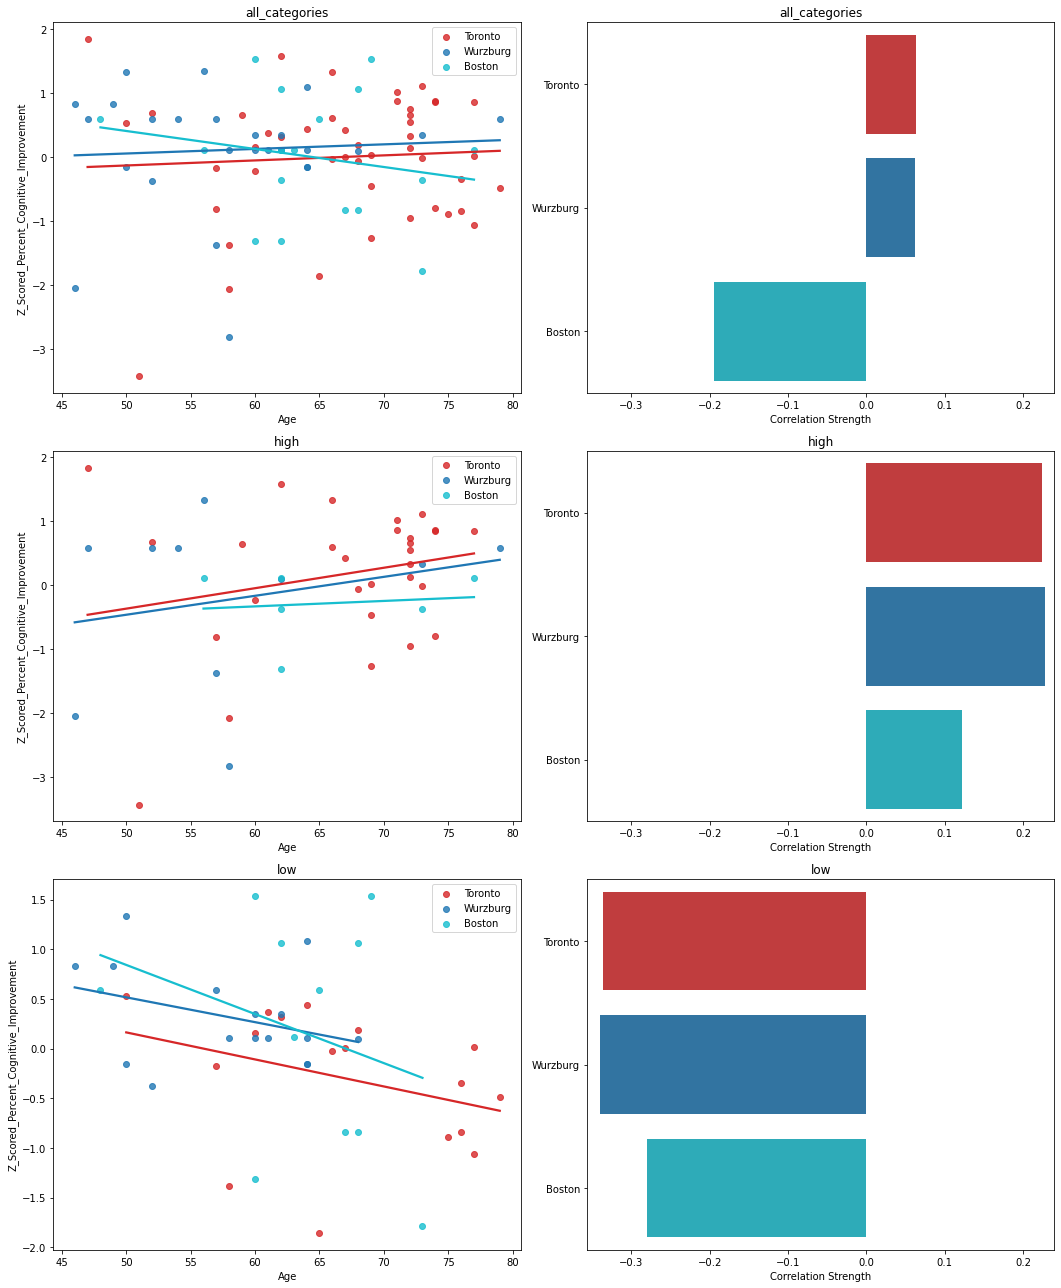

In [431]:

# Prepare data
data_prep = DataPreparation(data_df, dependent_variable, independent_variable, categorical_variable, cohort_variable)

# Create scatter plot instance
scatter_plot = ScatterPlot(data_prep, colors_list=['#d62728', '#1f77b4', '#17becf'])

# Create bar plot instance
bar_plot = BarPlot(data_prep, method='pearson', colors_list=['#d62728', '#1f77b4', '#17becf'])

# Create combined plot instance
combined_plot = CombinedPlot(scatter_plot, bar_plot, out_dir='/Users/cu135/Library/CloudStorage/OneDrive-Personal/OneDrive_Documents/Research/2023/subiculum_cognition_and_age/figures/Figures/3_cohort_delta_r')
combined_plot.save_figure()


P-Values within Categories Across Cohorts

In [427]:
# Perform permutation analysis
perm_analysis = PermutationAnalysis(data_prep)
perm_analysis.run_analysis(n_permutations=10000)
p_values = perm_analysis.p_values
from pprint import pprint
pprint(p_values)

{'all_categories': {('Toronto', 'Boston'): 0.1913,
                    ('Toronto', 'Wurzburg'): 0.5047,
                    ('Wurzburg', 'Boston'): 0.2133},
 'high': {('Toronto', 'Boston'): 0.4082,
          ('Toronto', 'Wurzburg'): 0.489,
          ('Wurzburg', 'Boston'): 0.4169},
 'low': {('Toronto', 'Boston'): 0.5497,
         ('Toronto', 'Wurzburg'): 0.5002,
         ('Wurzburg', 'Boston'): 0.56}}


P-Values Across Categories Across Cohorts

In [428]:
# Perform cross-category permutation analysis
cross_cat_perm_analysis = CrossCategoryPermutationAnalysis(perm_analysis)
cross_cat_perm_analysis.run_cross_category_permutation_analysis(n_permutations=10000)
# Pretty print the cross-category p_values
from pprint import pprint
pprint(cross_cat_perm_analysis.p_values)

{('all_categories', 'high'): {('Boston', 'Boston'): nan,
                              ('Boston', 'Toronto'): nan,
                              ('Boston', 'Wurzburg'): nan,
                              ('Toronto', 'Boston'): nan,
                              ('Toronto', 'Toronto'): nan,
                              ('Toronto', 'Wurzburg'): nan,
                              ('Wurzburg', 'Boston'): nan,
                              ('Wurzburg', 'Toronto'): nan,
                              ('Wurzburg', 'Wurzburg'): nan},
 ('all_categories', 'low'): {('Boston', 'Boston'): nan,
                             ('Boston', 'Toronto'): nan,
                             ('Boston', 'Wurzburg'): nan,
                             ('Toronto', 'Boston'): nan,
                             ('Toronto', 'Toronto'): nan,
                             ('Toronto', 'Wurzburg'): nan,
                             ('Wurzburg', 'Boston'): nan,
                             ('Wurzburg', 'Toronto'): nan,
      

/usr/local/Caskroom/mambaforge/base/envs/nimlab_py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/Caskroom/mambaforge/base/envs/nimlab_py310/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


P-Values Across Categories (contrast all cohorts within category against all cohorts in another category)

In [429]:

# Perform contrast analysis
contrast_analysis = ContrastAnalysis(perm_analysis)
contrast_analysis.summate_correlations()
contrast_analysis.calculate_cross_dataframe_differences(n_permutations=10000)

# Pretty print the cross-dataframe p_values
from pprint import pprint
pprint(contrast_analysis.cross_dataframe_p_values)

{('all_categories', 'high'): 0.8165,
 ('all_categories', 'low'): 0.0707,
 ('high', 'low'): 0.019}


Save the permutation results

In [430]:
import os
from pprint import pformat

def save_dicts_as_py(out_dir, **dicts):
    """
    Save dictionaries as .py files in the specified directory with pretty-print formatting.

    Parameters:
    out_dir (str): Directory to save the Python files.
    **dicts: Arbitrary number of dictionaries to save, with keys as file names (without .py extension).
    """

    # Save each dictionary as a Python file
    for file_name, data in dicts.items():
        try:
            with open(os.path.join(out_dir, f"{file_name}.py"), 'w') as py_file:
                py_file.write(f"{file_name} = {pformat(data)}\n")
            print(f"Successfully saved {file_name}.py")
        except Exception as e:
            print(f"An unexpected error occurred while saving {file_name}.py: {e}")

# Save dictionaries as .py files
save_dicts_as_py(out_dir,
                 cross_cat_perm_analysis_p_values= cross_cat_perm_analysis.p_values,
                 contrast_analysis_cross_dataframe_p_values=contrast_analysis.cross_dataframe_p_values,
                 perm_analysis_p_values=perm_analysis.p_values)



Successfully saved cross_cat_perm_analysis_p_values.py
Successfully saved contrast_analysis_cross_dataframe_p_values.py
Successfully saved perm_analysis_p_values.py


# 05 - Delta Scatterplot (Pretty)

In [ ]:
# Redefining the class and its methods
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
import seaborn as sns
class ScatterWithConfidence:
    def __init__(self, data_df):
        self.data_df = data_df

    @staticmethod
    def compute_analytic_confidence_interval(x, y, x_vals):
        slope, intercept = np.polyfit(x, y, 1)
        y_fit = slope * x_vals + intercept
        
        residuals = y - (slope * x + intercept)
        stderr = np.sqrt(np.sum(residuals**2) / (len(y) - 2))
        
        t_value = t.ppf(0.975, df=len(x)-2)
        ci = t_value * stderr * np.sqrt(1/len(x) + (x_vals - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
        
        upper_bound = y_fit + ci
        lower_bound = y_fit - ci
        
        return y_fit, lower_bound, upper_bound

    def permute_data_and_difference_in_pearson_r(self, x_one, x_two, split_by, split_value, n_permutations=1000, permute_columns=[]):
        original_diff = self.data_df[self.data_df[split_by] < split_value][x_one].corr(self.data_df[self.data_df[split_by] < split_value][x_two]) - \
                       self.data_df[self.data_df[split_by] >= split_value][x_one].corr(self.data_df[self.data_df[split_by] >= split_value][x_two])

        permuted_diffs = []

        for _ in range(n_permutations):
            permuted_df = self.data_df.copy()
            for column in permute_columns:
                permuted_df[column] = np.random.permutation(permuted_df[column].values)
            
            diff = permuted_df[permuted_df[split_by] < split_value][x_one].corr(permuted_df[permuted_df[split_by] < split_value][x_two]) - \
                   permuted_df[permuted_df[split_by] >= split_value][x_one].corr(permuted_df[permuted_df[split_by] >= split_value][x_two])
            
            permuted_diffs.append(diff)

        p_value = np.mean([diff <= original_diff for diff in permuted_diffs])
        return original_diff, p_value

    def plot_with_analytic_ci_manual_pvalue(self, x_one, x_two, 
                                            split_by, split_value, 
                                            x_label='X1', y_label='X2', 
                                            upper_split_legend='Above Split', lower_split_legend='Below Split',
                                            alpha=0.3, manual_p_value=None, permute_column=None, 
                                            save=False, out_dir=None,
                                            colour1='red', colour2='blue'):
        fig, ax = plt.subplots(figsize=(6, 5))
        
        group1 = self.data_df[self.data_df[split_by] < split_value]
        group2 = self.data_df[self.data_df[split_by] >= split_value]

        ax.scatter(group1[x_one], group1[x_two], color=colour1, label=lower_split_legend, s=40, alpha=alpha, marker='o')
        ax.scatter(group2[x_one], group2[x_two], color=colour2, label=upper_split_legend, s=40, alpha=alpha, marker='o')
        
        x_vals = np.linspace(self.data_df[x_one].min(), self.data_df[x_one].max(), 400)
        
        for group, color in [(group1, colour1), (group2, colour2)]:
            y_fit, lower_bound, upper_bound = self.compute_analytic_confidence_interval(group[x_one], group[x_two], x_vals)
            ax.plot(x_vals, y_fit, color=color)
            # ax.fill_between(x_vals, lower_bound, upper_bound, color=color, alpha=alpha/4)
        
        if manual_p_value is None:
            if permute_column:
                rho, manual_p_value = self.permute_data_and_difference_in_pearson_r(x_one, x_two, split_by, split_value, n_permutations=10000, permute_columns=[permute_column])
            else:
                rho, manual_p_value = self.permute_data_and_difference_in_pearson_r(x_one, x_two, split_by, split_value, n_permutations=10000, permute_columns=[x_one, x_two, split_by])
        
        ax.set_title(f"\u0394 r = {rho:.2f} , p = {manual_p_value:.4f}")
        ax.set_ylabel(y_label)
        ax.set_xlabel(x_label)
        ax.legend(loc='best', frameon=False)
        ax.grid(False)
        sns.despine(ax=ax)
        
        if save and out_dir is not None:
            plt.savefig(f"{out_dir}/scatter_with_polyfit_and_analytic_ci.png", bbox_inches='tight')
            plt.savefig(f"{out_dir}/scatter_with_polyfit_and_analytic_ci.svg", bbox_inches='tight')
            print(f'Saved to {out_dir}/scatter_with_polyfit_and_analytic_ci.svg')
        return fig
    
class DeltaCorrelation(ScatterWithConfidence):
    def __init__(self, data_df):
        super().__init__(data_df)

    def plot_histogram_of_delta_r(self, x_one, x_two, split_by, split_value, n_permutations=1000, 
                                permute_columns=[], bins=50, one_tail=False, color_palette='dark'):
        # Generate the empirical distribution of delta_r
        delta_rs = []
        for _ in range(n_permutations):
            permuted_df = self.data_df.copy()
            for column in permute_columns:
                permuted_df[column] = np.random.permutation(permuted_df[column].values)

            delta_r = permuted_df[permuted_df[split_by] < split_value][x_one].corr(permuted_df[permuted_df[split_by] < split_value][x_two]) - \
                    permuted_df[permuted_df[split_by] >= split_value][x_one].corr(permuted_df[permuted_df[split_by] >= split_value][x_two])
            delta_rs.append(delta_r)

        # Calculate the observed delta_r
        observed_delta_r, _ = self.permute_data_and_difference_in_pearson_r(x_one, x_two, split_by, split_value, permute_columns=permute_columns)

        if one_tail:
            observed_delta_r = np.abs(observed_delta_r)
            delta_rs = np.abs(delta_rs)

        # Calculate p-value
        if one_tail:
            p_value = np.mean([delta_r >= observed_delta_r for delta_r in delta_rs])
        else:
            p_value = np.mean([delta_r <= observed_delta_r for delta_r in delta_rs])

        # Generate the displot (KDE + Histogram) using Seaborn
        sns.set_palette(color_palette)
        current_palette = sns.color_palette(color_palette)
        chosen_color = current_palette[4]
        plt.figure(figsize=(6, 5))
        g = sns.displot(delta_rs, kde=True, bins=bins, label="Empirical $\\Delta r$ Distribution", element="step",color='blue', alpha=.6)
        plt.axvline(x=observed_delta_r, color='red', linestyle='-', linewidth=1.5, label=f"Observed $\\Delta r$", alpha=0.6)
        plt.title(f"$\\Delta r$ = {observed_delta_r}, p = {p_value}")
        plt.xlabel("$\\Delta r$")
        plt.ylabel("Count")
        plt.legend()
        
        fig = g.fig
        
        fig.savefig(f"{out_dir}/hist_kde.png", bbox_inches='tight')
        fig.savefig(f"{out_dir}/hist_kde.svg", bbox_inches='tight')
        print(f'Saved to {out_dir}/hist_kde.svg')
    


In [ ]:
data_df.columns

In [ ]:
filtered_columns = [col for col in data_df.columns if 'Occ' in col]
print(filtered_columns)

Data To Plot

In [ ]:
data_df

In [ ]:
# Data Variables
dependent_variable = 'Percent_Cognitive_Improvement'
independent_variable = 'Subiculum_Connectivity_T_Redone'
split_by_var = 'Age' # This is the column which contains the values you are going to split the data by 
split_value_var = 65 # This is the value which will be used to determine how rows of the given column split the entire dataset

Labels for Plot

In [ ]:
# Plotting Variables
x_label = 'Standardized Subiculum Connectivity'
y_label = 'Standardized Percent Improvement'
legend_string_for_lower_split='under 65'
legend_string_for_upper_split='Over 65'

In [ ]:
delta_sctr = ScatterWithConfidence(data_df)
delta_sctr_plot = delta_sctr.plot_with_analytic_ci_manual_pvalue(
                                            x_one=independent_variable, x_two=dependent_variable,
                                            split_by=split_by_var, split_value=split_value_var,
                                            x_label=x_label, y_label=y_label,
                                            upper_split_legend=legend_string_for_upper_split, lower_split_legend=legend_string_for_lower_split,
                                            alpha=0.3, manual_p_value=None, permute_column=None,
                                            save=True, out_dir=out_dir,
                                            colour1='#FF0000', colour2='#0000FF')

In [ ]:
# Create an object from the new Seaborn-based class
histogram_plotter_seaborn = DeltaCorrelation(data_df)

# Generate the histogram using Seaborn
fig = histogram_plotter_seaborn.plot_histogram_of_delta_r(x_one=independent_variable, x_two=dependent_variable, 
                                                    split_by=split_by_var, split_value=split_value_var, 
                                                    n_permutations=10000, 
                                                    permute_columns=[independent_variable, dependent_variable, split_by_var], 
                                                    bins=50,
                                                    one_tail=True, 
                                                    color_palette='coolwarm')

# Overlay Multiple Correlations

In [ ]:
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_lines_of_best_fit_by_combinations(data_df, categorical_columns, x_var, y_var):
    # Find unique values in each column
    unique_values_per_column = [data_df[col].unique() for col in categorical_columns]

    # Generate all possible combinations of these unique values across the columns
    all_combinations = list(itertools.product(*unique_values_per_column))

    plt.figure(figsize=(12, 8))
    sns.set_palette('tab10')
    # For each combination, create a mask and apply it to the DataFrame
    for combination in all_combinations:
        mask = pd.Series(True, index=data_df.index)
        for col, val in zip(categorical_columns, combination):
            mask &= (data_df[col] == val)

        # Apply the mask to the DataFrame to get the subset
        masked_df = data_df[mask]
        
        # Skip if the masked_df is empty
        if masked_df.empty:
            continue

        # Calculate the line of best fit
        slope, intercept = np.polyfit(masked_df[x_var], masked_df[y_var], 1)
        x_vals = np.linspace(masked_df[x_var].min(), masked_df[x_var].max(), 100)
        y_vals = slope * x_vals + intercept

        # Plot the line of best fit
        plt.plot(x_vals, y_vals, label=f'{combination}', linestyle='-')

    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.title(f'Lines of Best Fit for {x_var} vs {y_var} by Category Combinations')
    plt.legend(title='Category Combination', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
data_df.columns

In [ ]:
plot_lines_of_best_fit_by_combinations(data_df,
                                       categorical_columns=['Age_Group', 'City'], 
                                       x_var='Z_Scored_Subiculum_T_By_Origin_Group_', 
                                       y_var='Z_Scored_Percent_Cognitive_Improvement')

# Correlation Matrix and Heatmap

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_heatmap(dataframe):
    # Calculate the correlation matrix
    corr_matrix = dataframe.corr()

    # Create a heatmap
    plt.figure(figsize=(20, 16))
    sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={'shrink': .5})

    # Adjust the layout
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.title('Correlation Heatmap')

    # Show the plot
    plt.show()


In [ ]:
# Example usage
sorted_columns = sorted(data_df.columns)
data_df_sorted = data_df[sorted_columns]
plot_correlation_heatmap(data_df)

# Canonical Correlation

In [ ]:
from sklearn.cross_decomposition import CCA

def perform_cca(data_df, set1_columns, set2_columns):
    """
    Perform Canonical Correlation Analysis (CCA) between two sets of columns in a DataFrame.

    Parameters:
        data_df (pd.DataFrame): The DataFrame containing the data.
        set1_columns (list): List of column names for the first set of variables.
        set2_columns (list): List of column names for the second set of variables.

    Returns:
        cca (CCA): The CCA model object.
        cca_results (dict): A dictionary containing the CCA results.
    """
    # Extract the specified sets of columns from the DataFrame
    set1_data = data_df[set1_columns]
    set2_data = data_df[set2_columns]

    # Initialize the CCA model
    cca = CCA(n_components=min(len(set1_columns), len(set2_columns)))

    # Fit the CCA model to the data
    cca.fit(set1_data, set2_data)

    # Transform the data using CCA
    set1_transformed, set2_transformed = cca.transform(set1_data, set2_data)

    # Calculate canonical correlations from singular values
    canonical_correlations = cca.singular_values_

    # Store the CCA results in a dictionary
    cca_results = {
        'Canonical Correlations': canonical_correlations,
        'Set 1 Transformed': set1_transformed,
        'Set 2 Transformed': set2_transformed
    }

    return cca, cca_results

define 2 lists
- 1 is the first set to CCA
- 2 is the second set to CCA

In [ ]:
data_df.columns

In [ ]:
templist = []
for val in data_df.columns:
    if 'CSF' in val:
        templist.insert(-1, val)
print(templist)

In [ ]:
list1 = ['frontal', 'temporal', 'parietal', 'occipital',
       'cerebellum', 'Mesial_Temporal', 'ventricle']
list2 = ['frontal_eh', 'temporal_eh', 'parietal_eh',
       'occipital_eh', 'cerebellum_eh']

In [ ]:
from sklearn.cross_decomposition import CCA

def perform_cca(data_df, set1_columns, set2_columns):
    """
    Perform Canonical Correlation Analysis (CCA) between two sets of columns in a DataFrame.

    Parameters:
        data_df (pd.DataFrame): The DataFrame containing the data.
        set1_columns (list): List of column names for the first set of variables.
        set2_columns (list): List of column names for the second set of variables.

    Returns:
        cca (CCA): The CCA model object.
        cca_results (dict): A dictionary containing the CCA results.
    """
    # Extract the specified sets of columns from the DataFrame
    set1_data = data_df[set1_columns]
    set2_data = data_df[set2_columns]

    # Initialize the CCA model
    cca = CCA(n_components=min(len(set1_columns), len(set2_columns)))

    # Fit the CCA model to the data
    cca.fit(set1_data, set2_data)

    # Calculate canonical correlations using the score method
    canonical_correlations = cca.score(set1_data, set2_data)

    # Store the CCA results in a dictionary
    cca_results = {
        'Canonical Correlations': canonical_correlations
    }

    return cca, cca_results


In [ ]:
cca, cca_results = perform_cca(data_df, set1_columns=list1, set2_columns=list2)
cca_results

# Intraclass Correlation

In [ ]:
import matplotlib.patches as mpatches
from pingouin import intraclass_corr
from calvin_utils.statistical_utils.distribution_statistics import BootstrappedDistributionStatistics
from calvin_utils.statistical_utils.resampling_functions import Bootstrap

def calculate_icc(df, col1, col2):
    # Select only the specified columns and rename them for compatibility with pingouin
    data = df[[col1, col2]].rename(columns={col1: 'rating1', col2: 'rating2'})

    # Reshape data for pingouin's intraclass_corr function
    df_melted = data.melt(value_vars=['rating1', 'rating2'], var_name='rater', value_name='rating')
    df_melted['subject'] = df_melted.groupby('rater').cumcount()

    # Calculate ICC
    icc_result = intraclass_corr(data=df_melted, targets='subject', raters='rater', ratings='rating')
    
    # Return ICC(3,1)
    return icc_result.set_index('Type').loc['ICC3', 'ICC']

def bootstrap_icc(data, col1, col2, bootstrap_samples=2500):
    # Perform the bootstrap resampling using the Bootstrap class
    bootstrap = Bootstrap(data=data, func=calculate_icc, func_args={'col1': col1, 'col2': col2}, bootstrap_samples=bootstrap_samples)
    bootstrap_results = bootstrap.bootstrap_function()

    # Calculate the confidence intervals using the BootstrappedDistributionStatistics class
    distribution_statistics = BootstrappedDistributionStatistics(bootstrap_results)
    lower_bound, upper_bound = distribution_statistics.percentile_ci(alpha=0.05)

    return lower_bound, upper_bound

def plot_icc_forest(comparisons_dict, dataframe, bootstrap_samples=2500, full_legend_patches=False):
    # figure = plt.figure(figsize=(4, len(comparisons_dict)*1.2))
    figure = plt.figure(figsize=(4, 5))
    
    # Create a color palette with enough unique colors
    colors = sns.color_palette("tab10", len(comparisons_dict))
    
    # Create legend patches
    legend_patches = []
    
    # Iterate through the dictionary and plot ICC for each comparison
    for idx, (col1_name, col2_name) in enumerate(comparisons_dict.items()):
        # Calculate ICC
        icc_value = calculate_icc(dataframe, col1_name, col2_name)

        # Bootstrap 95% confidence interval
        ci_lower, ci_upper = bootstrap_icc(dataframe, col1_name, col2_name, bootstrap_samples=bootstrap_samples)

        # Plot ICC with confidence interval
        plt.errorbar(x=icc_value, y=idx, xerr=[[icc_value - ci_lower], [ci_upper - icc_value]], fmt='o', color=colors[idx], capsize=5)
        
        # Add legend patch
        if full_legend_patches:
            legend_patches.append(mpatches.Patch(color=colors[idx], label=f'{col1_name} vs {col2_name}'))
        else:
            legend_patches.append(mpatches.Patch(color=colors[idx], label=f'{col1_name}'))

    plt.xlim(0, 1)
    plt.ylim(-1, len(comparisons_dict))
    plt.yticks([])
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.xlabel('ICC')
    plt.title('Intraclass Correlation Coefficients (ICC) with 95% Confidence Intervals')
    plt.grid(axis='x', linestyle='--')
    
    # Add legend
    plt.legend(handles=legend_patches, frameon=False, loc=(0.05, 0.1))
    return figure